In [231]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from pandas.plotting import scatter_matrix

pd.options.display.max_columns = 99
pd.options.display.max_rows = 99

In [232]:
dataZAP = pd.read_csv('./data/dataZAP.csv', encoding='utf-8', sep=';', dtype=str ,low_memory=False)
new_data = pd.read_csv('./data/new_scraped_dataZAP.csv', encoding='utf-8', sep=';', dtype=str ,low_memory=False)

data = pd.concat([dataZAP, new_data])

# Tratamento dos dados

In [233]:
# Informações irrelevantes
data = data.drop(['account.licenseNumber', 'account.name', 'listing.acceptExchange',
                  'listing.address.zipCode', 'listing.advertiserId', 'listing.createdAt', 'listing.updatedAt',
                  'listing.externalId', 'listing.id','listing.isInactive', 'listing.legacyId', 'listing.link', 
                  'listing.portal', 'listing.preview', 'type', 'listing.address.confidence',  'listing.address.level', 'listing.businessTypeContext',
                  'listing.totalAreas', 'listing.unitTypes', 'listing.pricingInfo.rentalTotalPrice', 'listing.address.point.source', 'listing.address.precision', 'listing.address.streetNumber',
                  'listing.pricingInfo.businessType', 'listing.listingType', 'listing.pricingInfo.businessLabel',
                  'listing.propertyType', 'listing.title', 'listing.subtitle', 'listing.displayAddressType',
                  'listing.address.country', 'listing.pricingInfo.isRent', 'listing.publicationType',
                  'listing.pricingInfo.salePrice', 'listing.floors', 'listing.unitsOnTheFloor', 'listing.unitFloor', 'listing.unitSubTypes',
                  'listing.address.street', 'listing.address.zone', 'listing.usageTypes', 'listing.pricingInfo.price'], axis=1)

# Amenities
data = data.drop(['listing.backyard', 'listing.barbgrill' ,	'listing.bathtub', 'listing.fireplace', 'listing.furnished',
                  'listing.garden', 'listing.guestpark', 'listing.gym', 'listing.hottub', 'listing.mountainview', 
                  'listing.partyhall', 'listing.playground', 'listing.pool', 'listing.sauna',
                  'listing.soundproofing', 'listing.sportcourt', 'listing.tenniscourt'], axis=1)

In [234]:
# Removendo imoveis alugados por temporada
to_remove = data.query('`listing.pricingInfo.period` == "dia" or `listing.pricingInfo.period` == "semana" or `listing.pricingInfo.period` == "ano"')
data = data.drop(to_remove.index)

data = data.drop('listing.pricingInfo.period', axis=1)

In [235]:
# Removendo linhas duplicadas
data = data.drop_duplicates()

In [236]:
# Reseta o index da tabela
data.reset_index(inplace=True)
data = data.drop('index', axis=1)

In [237]:
data.head(10)

,imvl_type,listing.address.city,listing.address.neighborhood,listing.address.point.lat,listing.address.point.lon,listing.address.state,listing.amenities,listing.bathrooms,listing.bedrooms,listing.description,listing.parkingSpaces,listing.pricingInfo.isSale,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.rentalPrice,listing.pricingInfo.yearlyIptu,listing.suites,listing.usableAreas
0,apartamentos,São Paulo,Parada Inglesa,-23.493796,-46.605705,São Paulo,normal,1,2,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,normal,False,50,1.300,50,normal,45
1,apartamentos,Florianópolis,Agronômica,-27.576887,-48.54293,Santa Catarina,KITCHEN_CABINETS|BUILTIN_WARDROBE|BALCONY|SERV...,3,3,EXCELENTE LOCALIZAÇÃO - TRANQUILIDADE E COMODI...,1,False,1.961,3.600,370,1,140
2,apartamentos,Rio de Janeiro,Recreio Dos Bandeirantes,-23.018798,-43.462056,Rio de Janeiro,ELEVATOR|INTERCOM|KITCHEN_CABINETS|BUILTIN_WAR...,3,3,Cód: TIAP32493. Para quem quer morar próximo d...,2,False,835,2.100,244,1,100
3,apartamentos,Campinas,Cambuí,-22.899193,-47.053086,São Paulo,POOL|SAUNA,2,1,Apartamento mobiliado para alugar no Cambuí.<b...,1,False,134.437,3.000,90,0,80
4,apartamentos,São Paulo,Ipiranga,-23.598672,-46.604629,São Paulo,BARBECUE_GRILL|POOL|ELEVATOR|PLAYGROUND|SPORTS...,3,2,"Alugue rápido, sem fiador e com segurança! Age...",2,False,536,2.600,17,2,69
5,apartamentos,Rio de Janeiro,Barra da Tijuca,-23.003721,-43.328289,Rio de Janeiro,GARDEN|ELEVATOR|BARBECUE_GRILL|AIR_CONDITIONIN...,1,2,O apartamento no bairro Barra da Tijuca tem 64...,1,False,809,2.500,236,1,64
6,apartamentos,São Paulo,Brooklin,-23.613943,-46.690936,São Paulo,BARBECUE_GRILL|POOL|ELEVATOR|FURNISHED|LAUNDRY...,2,1,"Alugue rápido, sem fiador e com segurança! Age...",1,False,880,4.900,109,1,67
7,apartamentos,São Paulo,Tatuapé,-23.54083,-46.553211,São Paulo,BARBECUE_GRILL|POOL|SAFETY_CIRCUIT|SPORTS_COUR...,2,2,"Amplo apartamento com piso laminado, cozinha e...",1,False,800,1.900,132,1,73
8,apartamentos,São José do Rio Preto,Jardim Panorama,-20.831243,-49.399459,São Paulo,INTERCOM|SERVICE_AREA,2,2,Atualizado em,1,False,450,1.400,73,2,70
9,apartamentos,Porto Alegre,Jardim Botânico,-30.052912,-51.185236,Rio Grande do Sul,GATED_COMMUNITY|SERVICE_AREA|INTERCOM,1,2,Excelente apartamento com pintura e synteko no...,0,False,260,1.000,30,0,52


In [238]:
# Remove o "." da string para preservar o valor correto na conversão para float e converte para valores numéricos

data['listing.pricingInfo.monthlyCondoFee'] = data['listing.pricingInfo.monthlyCondoFee'].str.replace('.', '')
data['listing.pricingInfo.rentalPrice'] = data['listing.pricingInfo.rentalPrice'].str.replace('.', '')
data['listing.usableAreas'] = data['listing.usableAreas'].str.replace('.', '')
data['listing.pricingInfo.yearlyIptu'] = data['listing.pricingInfo.yearlyIptu'].str.replace('.', '')

# errors='coerce' - Os valores 'normal' são convertidos em 'NaN'
data['listing.usableAreas'] = pd.to_numeric(data['listing.usableAreas'], errors='coerce')

data['listing.pricingInfo.monthlyCondoFee'] = pd.to_numeric(data['listing.pricingInfo.monthlyCondoFee'], errors='coerce')
data['listing.pricingInfo.rentalPrice'] = pd.to_numeric(data['listing.pricingInfo.rentalPrice'], errors='coerce')
data['listing.pricingInfo.yearlyIptu'] = pd.to_numeric(data['listing.pricingInfo.yearlyIptu'], errors='coerce')

data['listing.address.point.lat'] = pd.to_numeric(data['listing.address.point.lat'],errors='coerce')
data['listing.address.point.lon'] = pd.to_numeric(data['listing.address.point.lon'],errors='coerce')

data['listing.suites'] = pd.to_numeric(data['listing.suites'], errors = 'coerce')
data['listing.bedrooms'] = pd.to_numeric(data['listing.bedrooms'], errors='coerce')
data['listing.bathrooms'] = pd.to_numeric(data['listing.bathrooms'], errors='coerce')
data['listing.parkingSpaces'] = pd.to_numeric(data['listing.parkingSpaces'], errors = 'coerce')

# Booleano
data['listing.pricingInfo.isSale'] = data['listing.pricingInfo.isSale'].astype(bool)


/tmp/ipykernel_53507/3351346572.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['listing.pricingInfo.monthlyCondoFee'] = data['listing.pricingInfo.monthlyCondoFee'].str.replace('.', '')
/tmp/ipykernel_53507/3351346572.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['listing.pricingInfo.rentalPrice'] = data['listing.pricingInfo.rentalPrice'].str.replace('.', '')
/tmp/ipykernel_53507/3351346572.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['listing.usableAreas'] = data['listing.usableAreas'].st

In [239]:
data.head(10)

,imvl_type,listing.address.city,listing.address.neighborhood,listing.address.point.lat,listing.address.point.lon,listing.address.state,listing.amenities,listing.bathrooms,listing.bedrooms,listing.description,listing.parkingSpaces,listing.pricingInfo.isSale,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.rentalPrice,listing.pricingInfo.yearlyIptu,listing.suites,listing.usableAreas
0,apartamentos,São Paulo,Parada Inglesa,-23.493796,-46.605705,São Paulo,normal,1.0,2.0,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,NaN,True,50.0,1300,50.0,NaN,45.0
1,apartamentos,Florianópolis,Agronômica,-27.576887,-48.542930,Santa Catarina,KITCHEN_CABINETS|BUILTIN_WARDROBE|BALCONY|SERV...,3.0,3.0,EXCELENTE LOCALIZAÇÃO - TRANQUILIDADE E COMODI...,1.0,True,1961.0,3600,370.0,1.0,140.0
2,apartamentos,Rio de Janeiro,Recreio Dos Bandeirantes,-23.018798,-43.462056,Rio de Janeiro,ELEVATOR|INTERCOM|KITCHEN_CABINETS|BUILTIN_WAR...,3.0,3.0,Cód: TIAP32493. Para quem quer morar próximo d...,2.0,True,835.0,2100,244.0,1.0,100.0
3,apartamentos,Campinas,Cambuí,-22.899193,-47.053086,São Paulo,POOL|SAUNA,2.0,1.0,Apartamento mobiliado para alugar no Cambuí.<b...,1.0,True,134437.0,3000,90.0,0.0,80.0
4,apartamentos,São Paulo,Ipiranga,-23.598672,-46.604629,São Paulo,BARBECUE_GRILL|POOL|ELEVATOR|PLAYGROUND|SPORTS...,3.0,2.0,"Alugue rápido, sem fiador e com segurança! Age...",2.0,True,536.0,2600,17.0,2.0,69.0
5,apartamentos,Rio de Janeiro,Barra da Tijuca,-23.003721,-43.328289,Rio de Janeiro,GARDEN|ELEVATOR|BARBECUE_GRILL|AIR_CONDITIONIN...,1.0,2.0,O apartamento no bairro Barra da Tijuca tem 64...,1.0,True,809.0,2500,236.0,1.0,64.0
6,apartamentos,São Paulo,Brooklin,-23.613943,-46.690936,São Paulo,BARBECUE_GRILL|POOL|ELEVATOR|FURNISHED|LAUNDRY...,2.0,1.0,"Alugue rápido, sem fiador e com segurança! Age...",1.0,True,880.0,4900,109.0,1.0,67.0
7,apartamentos,São Paulo,Tatuapé,-23.540830,-46.553211,São Paulo,BARBECUE_GRILL|POOL|SAFETY_CIRCUIT|SPORTS_COUR...,2.0,2.0,"Amplo apartamento com piso laminado, cozinha e...",1.0,True,800.0,1900,132.0,1.0,73.0
8,apartamentos,São José do Rio Preto,Jardim Panorama,-20.831243,-49.399459,São Paulo,INTERCOM|SERVICE_AREA,2.0,2.0,Atualizado em,1.0,True,450.0,1400,73.0,2.0,70.0
9,apartamentos,Porto Alegre,Jardim Botânico,-30.052912,-51.185236,Rio Grande do Sul,GATED_COMMUNITY|SERVICE_AREA|INTERCOM,1.0,2.0,Excelente apartamento com pintura e synteko no...,0.0,True,260.0,1000,30.0,0.0,52.0


In [240]:
# Cria uma coluna ALUGUEL na primeira posição para substituir a coluna listing.pricingInfo.rentalPrice
data.insert(0, 'ALUGUEL', data['listing.pricingInfo.rentalPrice'] )
data.drop('listing.pricingInfo.rentalPrice', axis=1, inplace=True)

## Tratamento de outliers

Aluguel

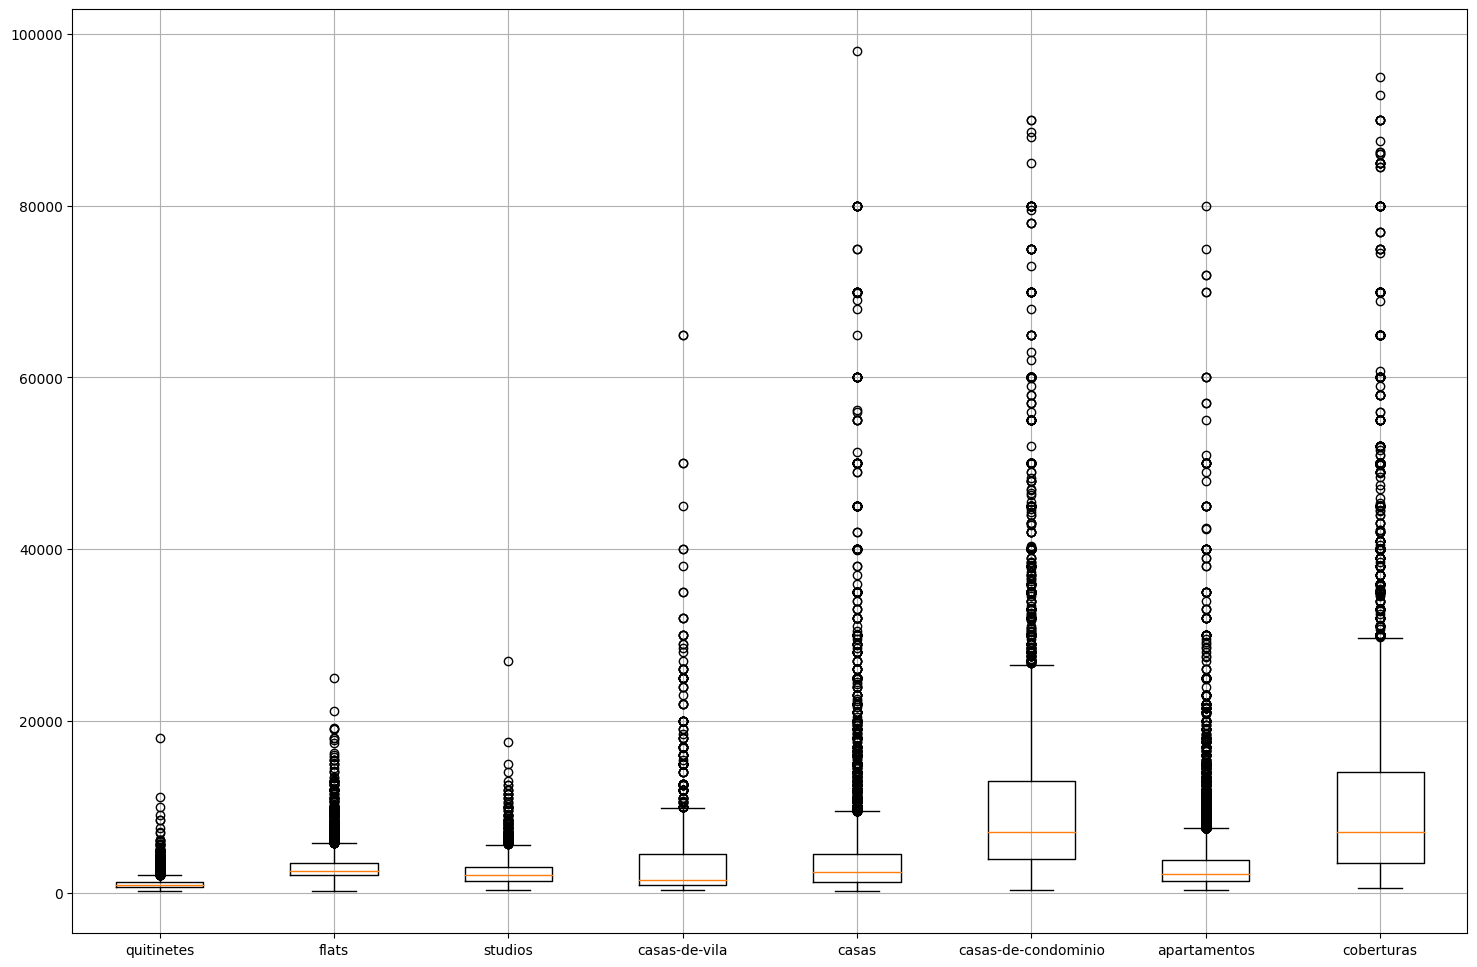

In [241]:
fig = plt.figure(figsize=(18, 12))
plt.boxplot([data.query('ALUGUEL < 100000 and imvl_type == "quitinetes"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "flat"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "studio"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "casas-de-vila"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "casas"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "casas-de-condominio"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "apartamentos"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "cobertura"')['ALUGUEL']],
            labels=['quitinetes', 'flats', 'studios', 'casas-de-vila', 'casas', 
                    'casas-de-condominio', 'apartamentos', 'coberturas'])
plt.grid()

In [242]:
data['ALUGUEL'].quantile(0.9)

14000.0

In [243]:
data.drop(data.query('ALUGUEL > 14000').index, inplace=True)

In [244]:
data.describe()

,ALUGUEL,listing.address.point.lat,listing.address.point.lon,listing.bathrooms,listing.bedrooms,listing.parkingSpaces,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.yearlyIptu,listing.suites,listing.usableAreas
count,69311.000000,42115.000000,42115.000000,69308.000000,69273.000000,64175.000000,4.700400e+04,4.740800e+04,58429.000000,6.931000e+04
mean,3427.352787,-22.349869,-46.386644,2.028669,2.104471,1.643397,1.048762e+03,6.860585e+02,1.059132,1.569097e+03
std,3038.877234,4.909251,3.178300,1.512564,1.199346,2.498986,1.146444e+04,2.136443e+04,1.180011,1.201076e+05
min,150.000000,-32.036215,-67.846294,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,0.000000e+00
25%,1200.000000,-23.600709,-47.115706,1.000000,1.000000,1.000000,3.300000e+02,6.900000e+01,0.000000,3.800000e+01
50%,2400.000000,-23.525726,-46.670405,1.000000,2.000000,1.000000,6.000000e+02,1.700000e+02,1.000000,7.000000e+01
75%,4500.000000,-22.880492,-46.339778,3.000000,3.000000,2.000000,1.120000e+03,3.810000e+02,1.000000,1.630000e+02
max,14000.000000,2.831258,-34.793932,20.000000,30.000000,403.000000,2.058000e+06,2.900000e+06,46.000000,9.999999e+06


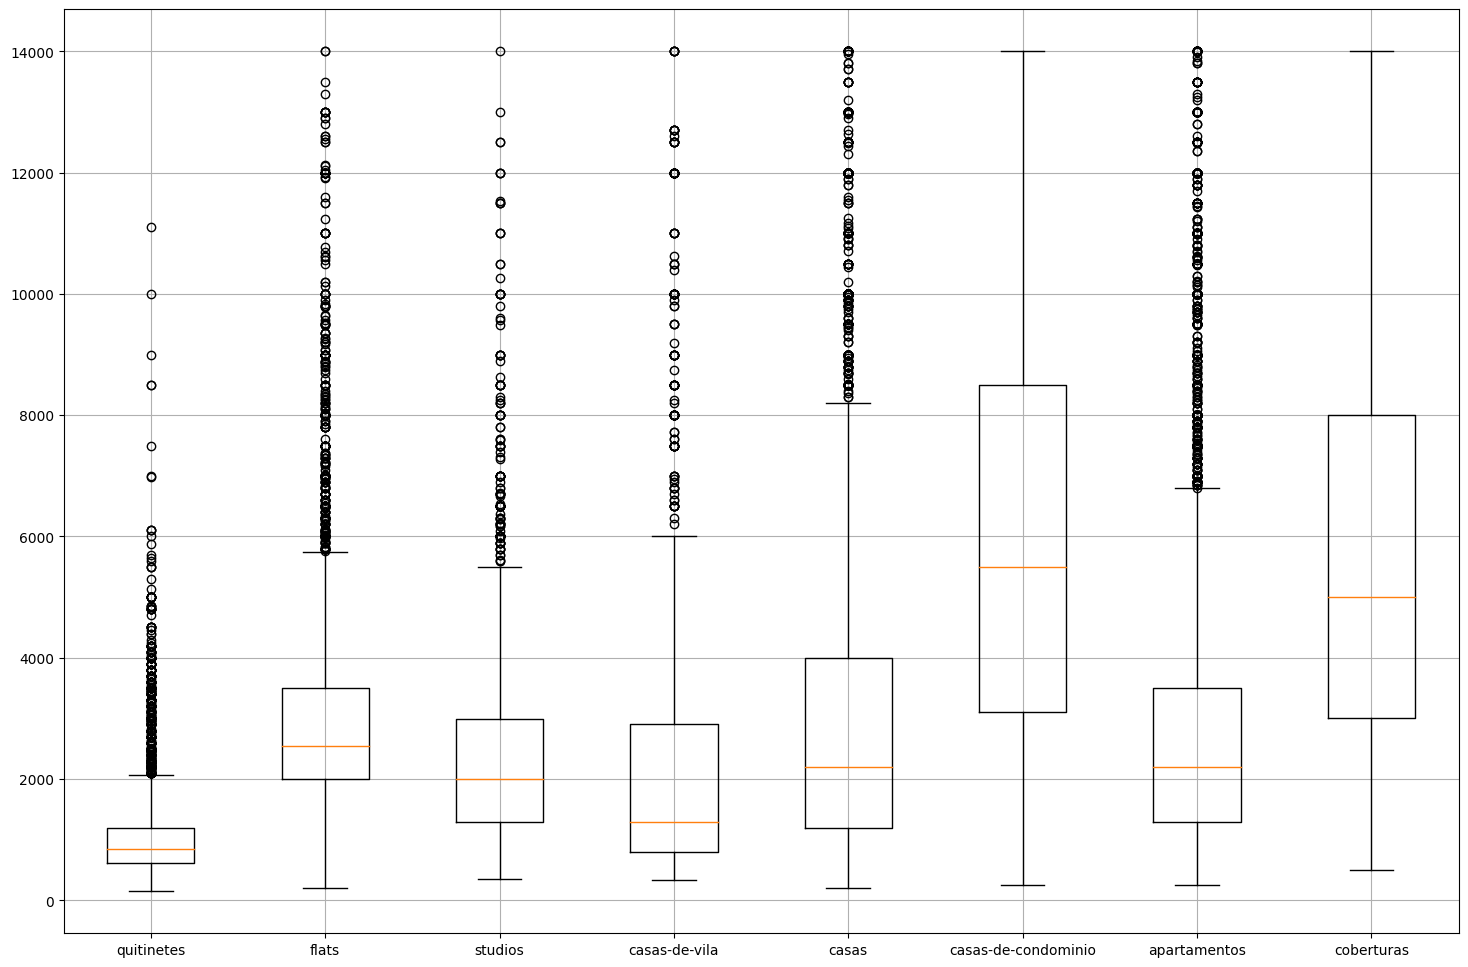

In [245]:
fig = plt.figure(figsize=(18, 12))
plt.boxplot([data.query('ALUGUEL < 100000 and imvl_type == "quitinetes"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "flat"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "studio"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "casas-de-vila"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "casas"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "casas-de-condominio"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "apartamentos"')['ALUGUEL'],
            data.query('ALUGUEL < 100000 and imvl_type == "cobertura"')['ALUGUEL']],
            labels=['quitinetes', 'flats', 'studios', 'casas-de-vila', 'casas', 
                    'casas-de-condominio', 'apartamentos', 'coberturas'])
plt.grid()

In [246]:
# verificando os outliers dos quitinetes é possivel observar que não são erros nos valores dos anuncios no ZAP

data.query(' imvl_type == "quitinetes" and ALUGUEL > 6000')[['ALUGUEL','listing.pricingInfo.monthlyCondoFee','listing.address.city','listing.address.neighborhood','listing.bathrooms','listing.bedrooms','listing.parkingSpaces','listing.usableAreas', 'listing.description']].values

array([[6975, 790.0, 'São Paulo', 'Itaim Bibi', 1.0, 1.0, 1.0, 54.0,
        'Mobiliado e equipado, 1suíte, living, cozinha, ar-condicionado, serviço de lavanderia e 1 vaga de garagem. Localizado à 800 metros do Shopping Iguatemi, Parque do Povo e à 300 metros da Avenida Brigadeiro Faria Lima. -'],
       [8500, 1500.0, 'São Paulo', 'Jardim Paulista', 2.0, 2.0, 2.0,
        88.0,
        'Studio Cobertura Duplex totalmente mobiliado, Com duas suítes, sacada ampla com fechamento em vidro, uma vaga de garagem, piso em porcelanato, moveis e eletrodomésticos novos, tudo planejado para atender você. Localizado à poucos metros do Parque do Ibirapuera. Áreas comuns totalmente mobiliadas e decoradas, contando com serviço de arrumação e lavanderia "pay per use", além de estacionamento com manobrista. Amplo fitness, piscina com pequena raia, áreas ajardinadas com paisagismo de Gil Fialho, lounge para festas e espaço gourmet completo, home office e lavanderia coletiva (HVB). O charme e a exclusiv

Condomínio

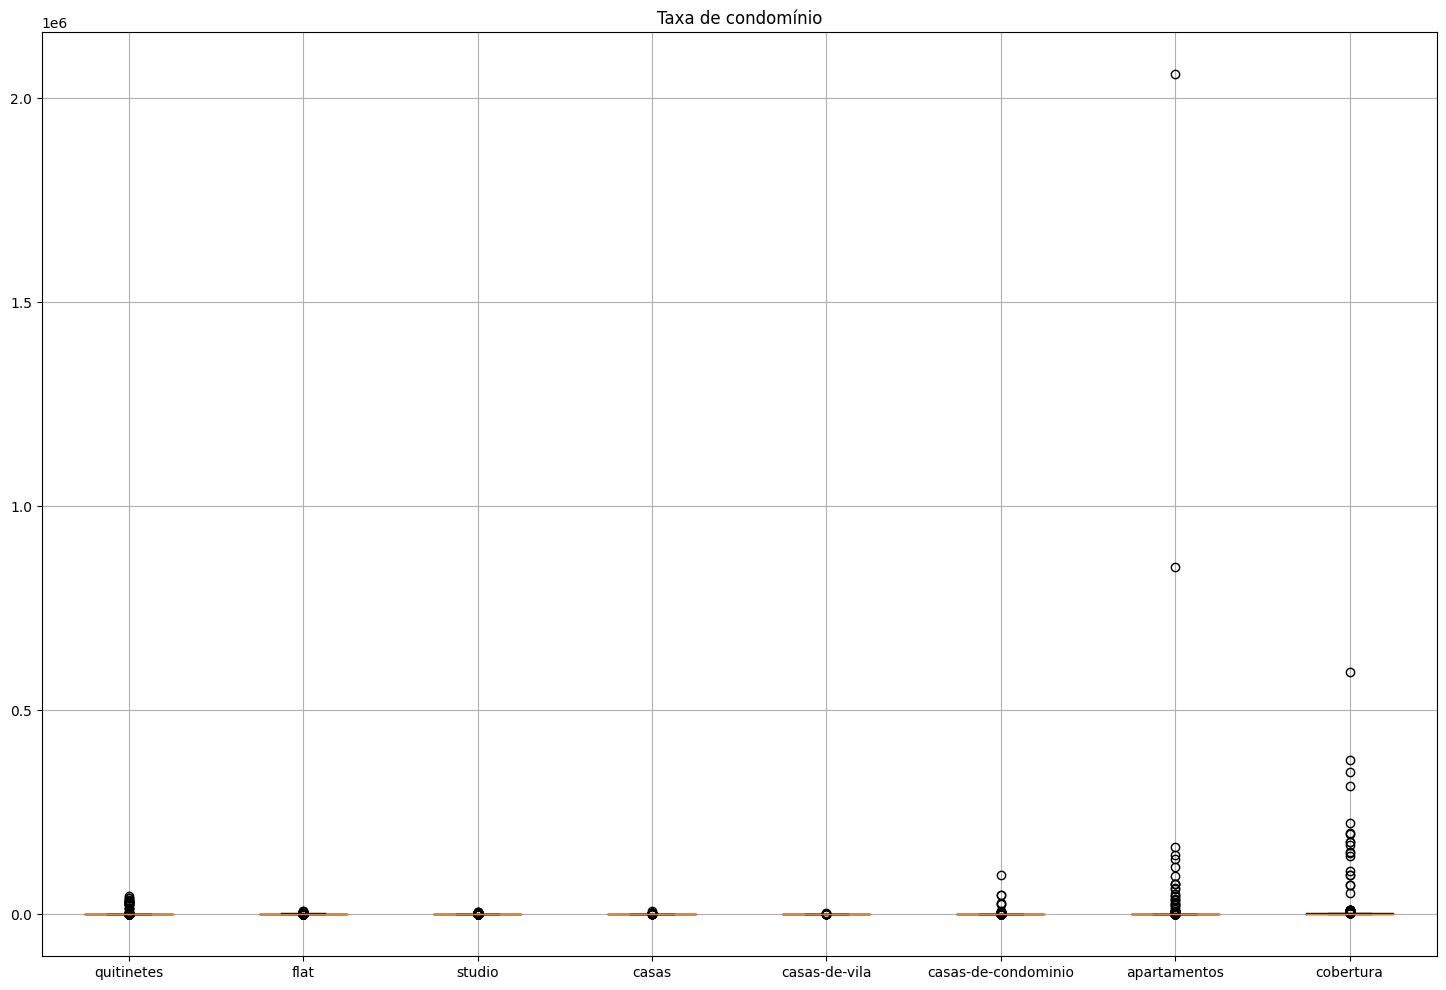

In [247]:
fig = plt.figure(figsize=(18, 12))
plt.boxplot( [data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "quitinetes"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "flat"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "studio"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "casas"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "casas-de-vila"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "casas-de-condominio"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "apartamentos"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "cobertura"')['listing.pricingInfo.monthlyCondoFee']],
             labels=['quitinetes', 'flat', 'studio', 'casas',
                     'casas-de-vila', 'casas-de-condominio',
                     'apartamentos', 'cobertura'])
plt.title('Taxa de condomínio')
plt.grid()
plt.show()

In [248]:
data['listing.pricingInfo.monthlyCondoFee'].quantile(1)

2058000.0

In [249]:
data.drop(data.query('`listing.pricingInfo.monthlyCondoFee` > 5000').index, inplace=True)

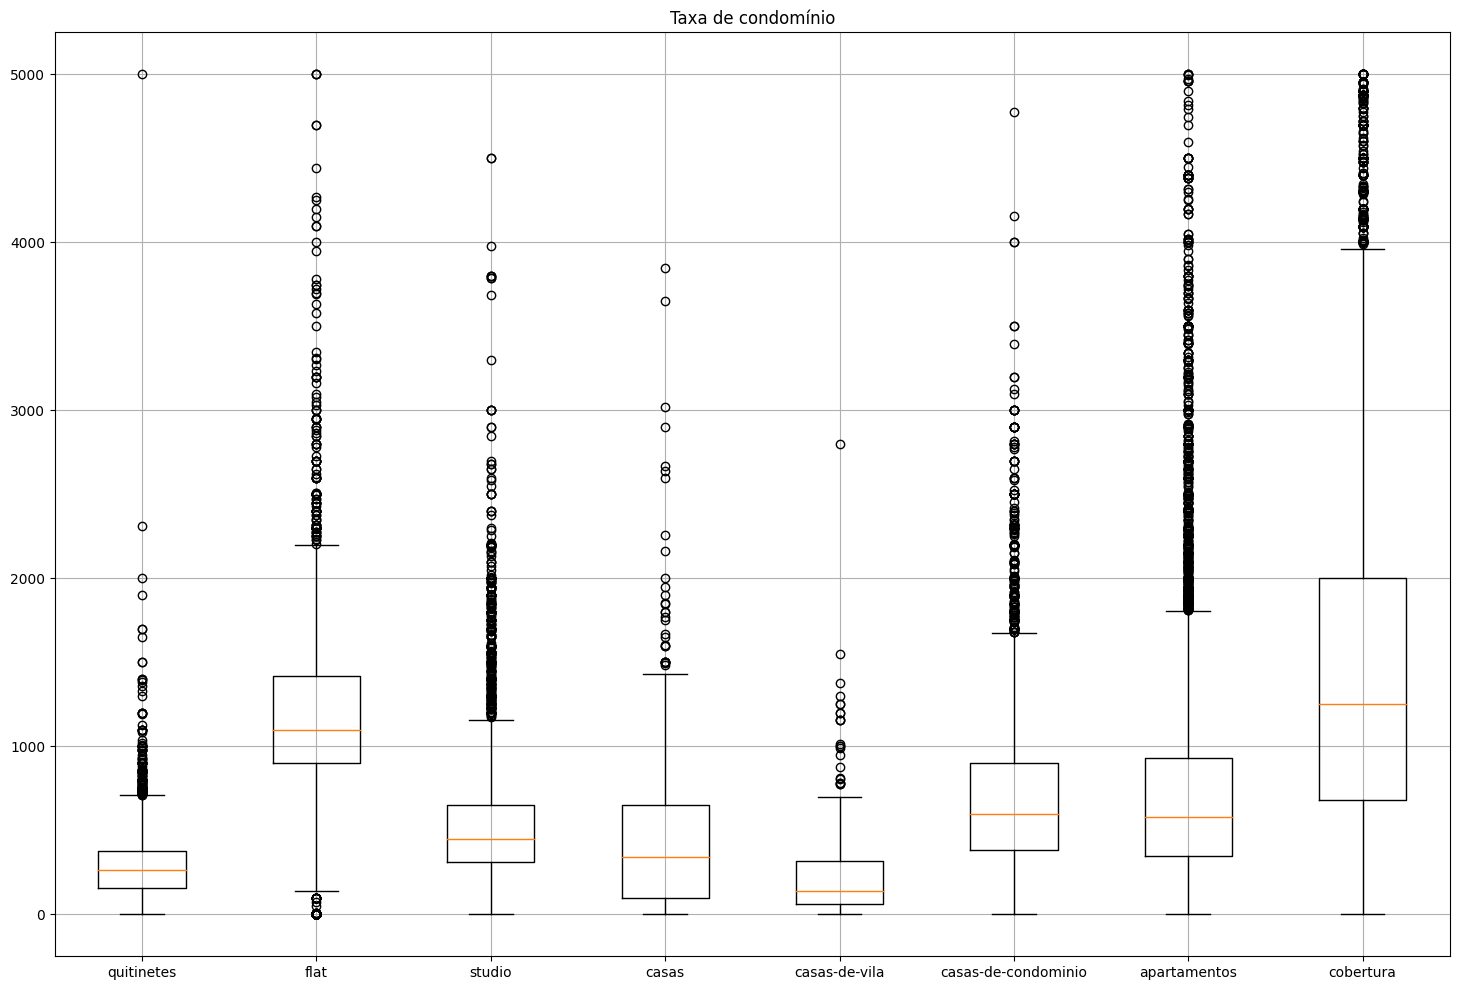

In [250]:
fig = plt.figure(figsize=(18, 12))
plt.boxplot( [data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "quitinetes"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "flat"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "studio"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "casas"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "casas-de-vila"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "casas-de-condominio"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "apartamentos"')['listing.pricingInfo.monthlyCondoFee'], 
              data[data['listing.pricingInfo.monthlyCondoFee'].notnull()].query('imvl_type == "cobertura"')['listing.pricingInfo.monthlyCondoFee']],
             labels=['quitinetes', 'flat', 'studio', 'casas',
                     'casas-de-vila', 'casas-de-condominio',
                     'apartamentos', 'cobertura'])
plt.title('Taxa de condomínio')
plt.grid()
plt.show()

In [251]:
# verificando os outliers é possivel observar que não são erros nos valores dos anuncios no ZAP

data.query('`listing.pricingInfo.monthlyCondoFee` > 3000')[['ALUGUEL','listing.pricingInfo.monthlyCondoFee','listing.address.city','listing.address.neighborhood','listing.bathrooms','listing.bedrooms','listing.parkingSpaces','listing.usableAreas', 'listing.description']].values

array([[12500, 3800.0, 'Rio de Janeiro', ..., 2.0, 260.0,
        '260m2 – apartamento de esquina com vista lateral mar e Jardim de Alah - prédio com grade, câmeras e portaria 24hs, 1 por andar – 2 vagas. Planta circular, claro e ventilado. Pintado e sintecado. Amplo salão com vista, lavabo, louceiro. 4 quartos sendo 1 suíte, todos c/ armários e Split. Banheiro social. Espaçosa cozinha, área de serviço e 2 dependências completas. Mobiliado ou não. Split em todos os cômodos.'],
       [3400, 3862.0, 'São Paulo', ..., 4.0, 373.0,
        'Living amplo ambientes integrados: varanda, sala de lareira, sala de jantar e sala de almoço cozinha planejada com despensa. 4 dormitórios com armários e terraços: sendo 3 suítes e mais dormitório com banheiro. A suíte master com hidro, terraço, closet, repletos de armários. 4 vagas demarcadas paralelas e depósito. Edifico possui lazer Completo com muito verde ao redor. Rua Tranquila sem saída e com cancela. -'],
       [5300, 3450.0, 'Rio de Janeiro', 

Quartos

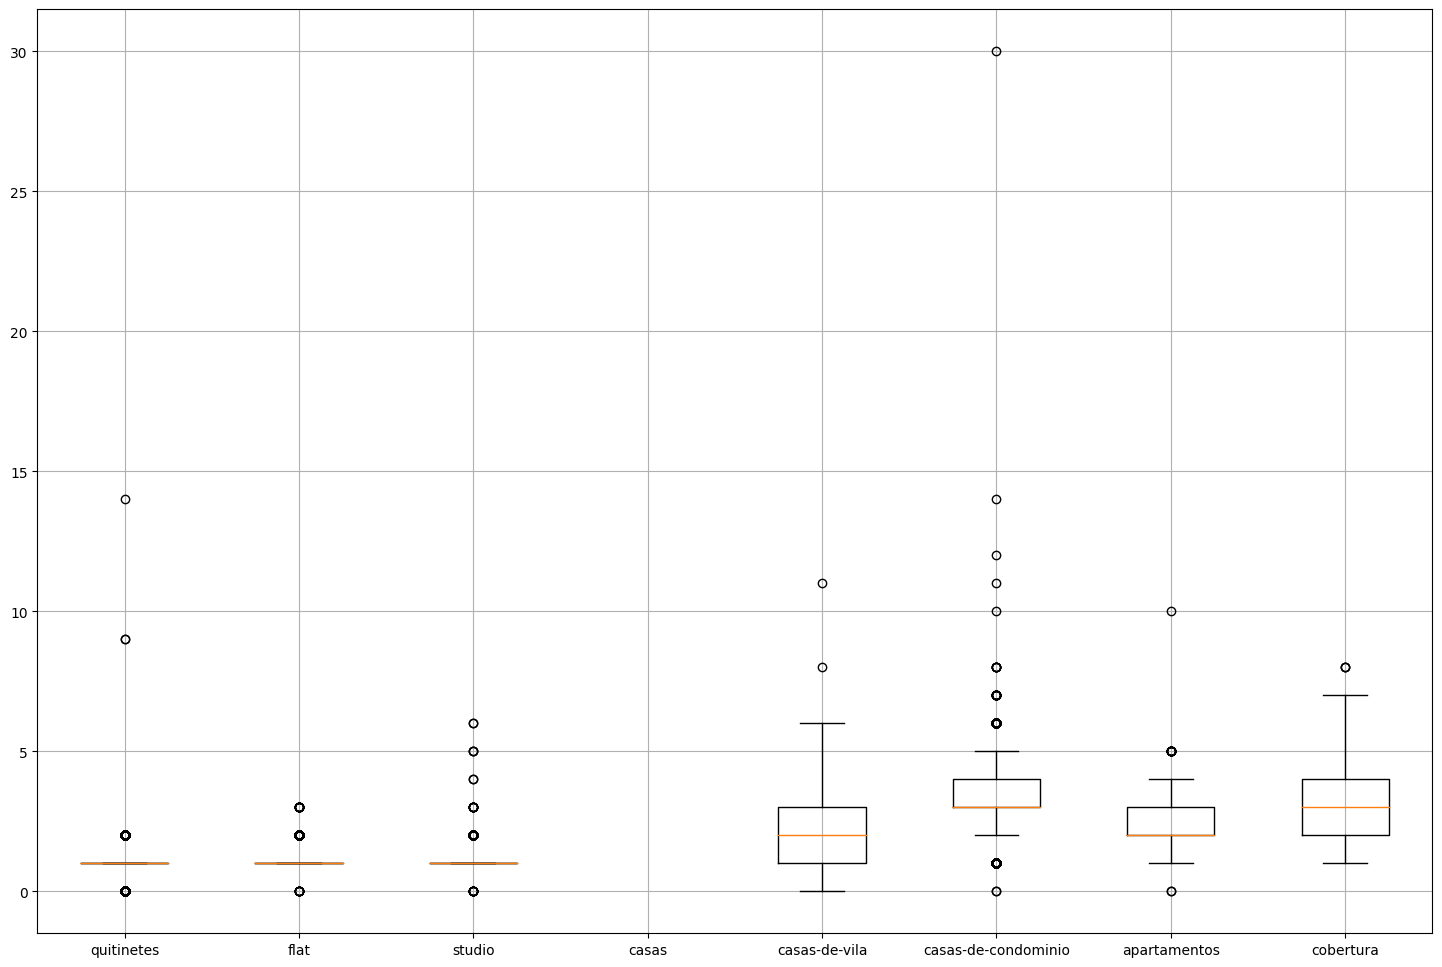

In [252]:
fig = plt.figure(figsize=(18, 12))
plt.boxplot( [data.query('imvl_type == "quitinetes"')['listing.bedrooms'], 
              data.query('imvl_type == "flat"')['listing.bedrooms'], 
              data.query('imvl_type == "studio"')['listing.bedrooms'], 
              data.query('imvl_type == "casas"')['listing.bedrooms'], 
              data.query('imvl_type == "casas-de-vila"')['listing.bedrooms'], 
              data.query('imvl_type == "casas-de-condominio"')['listing.bedrooms'], 
              data.query('imvl_type == "apartamentos"')['listing.bedrooms'], 
              data.query('imvl_type == "cobertura"')['listing.bedrooms'] ],
             labels=['quitinetes', 'flat', 'studio', 'casas',
                        'casas-de-vila', 'casas-de-condominio','apartamentos', 'cobertura'])
plt.grid()


In [253]:
data.query('imvl_type == "quitinetes" and `listing.bedrooms`>5')

,ALUGUEL,imvl_type,listing.address.city,listing.address.neighborhood,listing.address.point.lat,listing.address.point.lon,listing.address.state,listing.amenities,listing.bathrooms,listing.bedrooms,listing.description,listing.parkingSpaces,listing.pricingInfo.isSale,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.yearlyIptu,listing.suites,listing.usableAreas
23049,970,quitinetes,Belo Horizonte,Mangabeiras,-19.954045,-43.925085,Minas Gerais,KITCHEN_CABINETS|FURNISHED|RECREATION_AREA|BAR...,5.0,9.0,normal,7.0,True,NaN,NaN,5.0,30.0
23078,1100,quitinetes,São Paulo,Butantã,-23.582295,-46.740329,São Paulo,FURNISHED,0.0,14.0,ÓTIMAS SUÍTES NO BUTANTÃ-Jd.Bonfiglioli Dispon...,3.0,True,NaN,NaN,14.0,25.0
23098,680,quitinetes,Porto Alegre,Partenon,-30.051118,-51.171223,Rio Grande do Sul,AIR_CONDITIONING|KITCHEN_CABINETS|FURNISHED|BA...,3.0,9.0,"""Muitooo"" perto da PUC e UFRGS - Campus do Val...",0.0,True,NaN,NaN,1.0,16.0


In [254]:
# Remove quitinetes com mais que 5 quartos já que são erros nos dados

data.drop(data.query('imvl_type == "quitinetes" and `listing.bedrooms`>5').index, inplace=True)

Banheiros

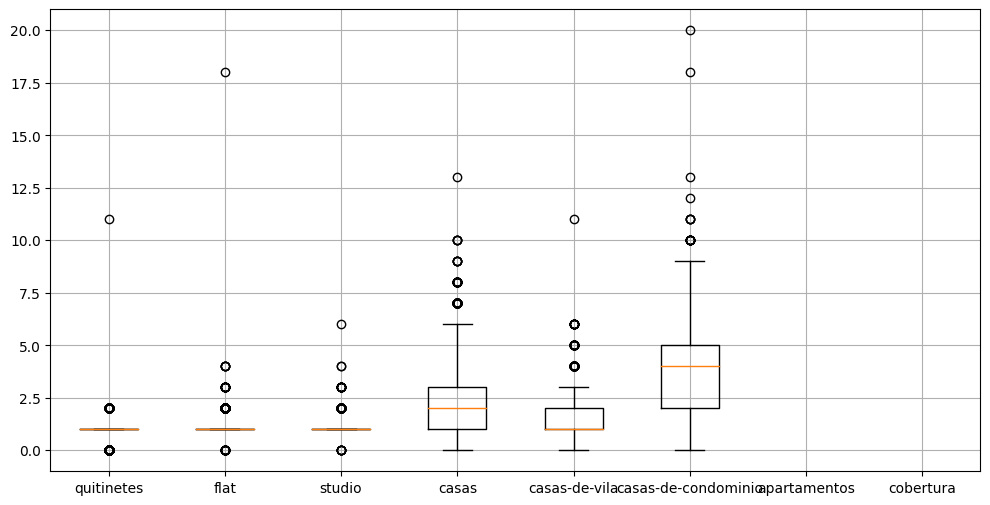

In [255]:
fig = plt.figure(figsize=(12, 6))
plt.boxplot( [data.query('imvl_type == "quitinetes"')['listing.bathrooms'], 
              data.query('imvl_type == "flat"')['listing.bathrooms'], 
              data.query('imvl_type == "studio"')['listing.bathrooms'], 
              data.query('imvl_type == "casas"')['listing.bathrooms'], 
              data.query('imvl_type == "casas-de-vila"')['listing.bathrooms'], 
              data.query('imvl_type == "casas-de-condominio"')['listing.bathrooms'], 
              data.query('imvl_type == "apartamentos"')['listing.bathrooms'], 
              data.query('imvl_type == "cobertura"')['listing.bathrooms'] ],
             labels=['quitinetes', 'flat', 'studio', 'casas',
                     'casas-de-vila', 'casas-de-condominio','apartamentos', 'cobertura'])
plt.grid()

In [256]:
data.drop(data.query('imvl_type == "quitinetes" and `listing.bathrooms`>5').index, inplace=True)

Suites

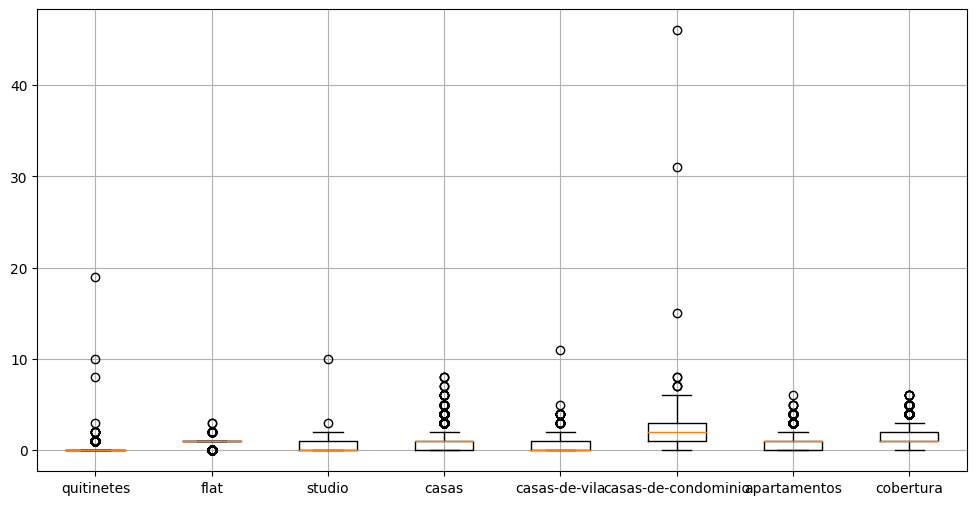

In [257]:
fig = plt.figure(figsize=(12, 6))
plt.boxplot( [data[data['listing.suites'].notnull()].query('imvl_type == "quitinetes"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "flat"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "studio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-vila"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-condominio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "apartamentos"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "cobertura"')['listing.suites'] ],
             labels=['quitinetes', 'flat', 'studio', 'casas', 'casas-de-vila', 'casas-de-condominio','apartamentos', 'cobertura'])
plt.grid()   
plt.show()

In [258]:
data.query('`listing.suites` > 10')

,ALUGUEL,imvl_type,listing.address.city,listing.address.neighborhood,listing.address.point.lat,listing.address.point.lon,listing.address.state,listing.amenities,listing.bathrooms,listing.bedrooms,listing.description,listing.parkingSpaces,listing.pricingInfo.isSale,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.yearlyIptu,listing.suites,listing.usableAreas
5247,5500,casas-de-condominio,Rio de Janeiro,Recreio Dos Bandeirantes,-23.000104,-43.372187,Rio de Janeiro,normal,6.0,4.0,CCO1155- Condomínio Nova Barra - Alugamos ótim...,2.0,True,850.0,400.0,46.0,280.0
45887,350,quitinetes,Fortaleza,Benfica,-3.735965,-38.538177,Ceará,RECEPTION|GATED_COMMUNITY|GARDEN|DISABLED_ACCE...,1.0,1.0,O kitnet/conjugado está localizado no bairro F...,0.0,True,NaN,30.0,19.0,22.0
53325,2500,casas-de-vila,Campo Grande,Vila Manoel Taveira,NaN,NaN,Mato Grosso do Sul,GATED_COMMUNITY,11.0,11.0,Aluguel facilitado sem fiador<br>A casa de vil...,1.0,True,NaN,NaN,11.0,182.0
53905,9900,casas-de-condominio,Goiânia,Jardim Florença,-16.722623,-49.312657,Goiás,RECEPTION|TREE_CLIMBING|GYM|GOURMET_SPACE|GARD...,6.0,4.0,"+ Residência de esquina, localizado na Alameda...",4.0,True,NaN,1.0,31.0,339.0
55360,12000,casas-de-condominio,Tremembé,Guedes,NaN,NaN,São Paulo,POOL|PLAYGROUND|PARTY_HALL|GAMES_ROOM|GYM|BARB...,18.0,30.0,A casa de condomínio está localizado no bairro...,24.0,True,101.0,380.0,15.0,1058.0


In [259]:
data.query('`listing.suites` > 10').values

array([[5500, 'casas-de-condominio', 'Rio de Janeiro',
        'Recreio Dos Bandeirantes', -23.000104, -43.372187,
        'Rio de Janeiro', 'normal', 6.0, 4.0,
        'CCO1155- Condomínio Nova Barra - Alugamos ótima casa com 4 suítes, sala de estar, sala de jantar, lavabo, escritório, cozinha, dependência de empregada e área de serviço.Armários planejados em todos os ambientes.Infraestrutura: piscina e churrasqueira.Segurança 24 horas.',
        2.0, True, 850.0, 400.0, 46.0, 280.0],
       [350, 'quitinetes', 'Fortaleza', 'Benfica', -3.735965, -38.538177,
        'Ceará',
        'RECEPTION|GATED_COMMUNITY|GARDEN|DISABLED_ACCESS|NEAR_HOSPITAL|NEAR_ACCESS_ROADS|NEAR_PUBLIC_TRANSPORT|SECURITY_24_HOURS|PETS_ALLOWED',
        1.0, 1.0,
        'O kitnet/conjugado está localizado no bairro Farias Brito tem 22 metros quadrados com 1 quarto sendo 19 suites e 19 banheiros<br>Possui espaço jardinado.<br>Além disso segurança garantida 24 horas por dia.Encontra-se em um condomínio protegido po

In [260]:
data.at[5247, 'listing.suites'] = 4
data.at[53905, 'listing.suites'] = 3
data.at[45887, 'listing.suites'] = 1

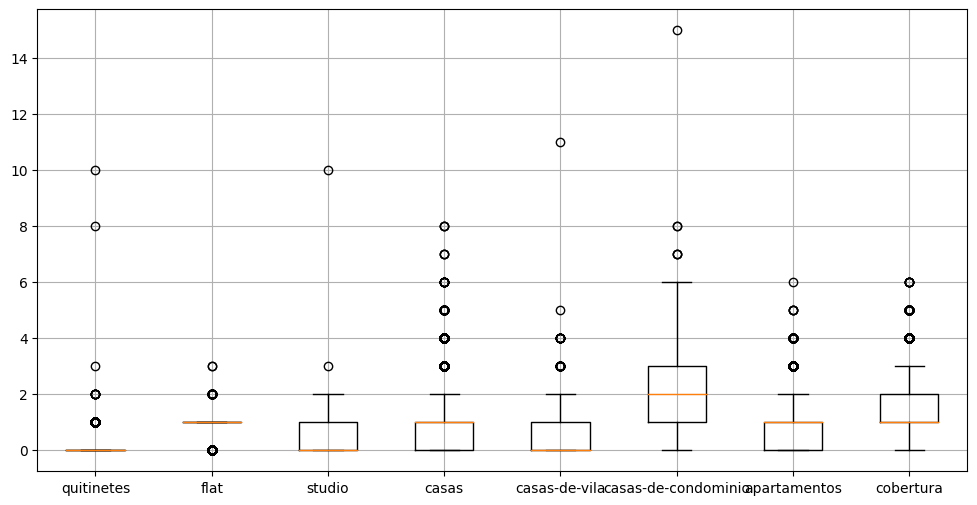

In [261]:
fig = plt.figure(figsize=(12, 6))
plt.boxplot( [data[data['listing.suites'].notnull()].query('imvl_type == "quitinetes"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "flat"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "studio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-vila"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-condominio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "apartamentos"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "cobertura"')['listing.suites'] ],
             labels=['quitinetes', 'flat', 'studio', 'casas', 'casas-de-vila', 'casas-de-condominio','apartamentos', 'cobertura'])
plt.grid()   
plt.show()

In [263]:
data.query('imvl_type == "quitinetes" and `listing.suites`> 2')['listing.suites']

19324    10.0
41479     3.0
42680     8.0
Name: listing.suites, dtype: float64

In [264]:
# lendo a descrição do anuncio eles possuem apenas 1 suite

data.at[19324, 'listing.suites'] = 1
data.at[41479, 'listing.suites'] = 1
data.at[42680, 'listing.suites'] = 1

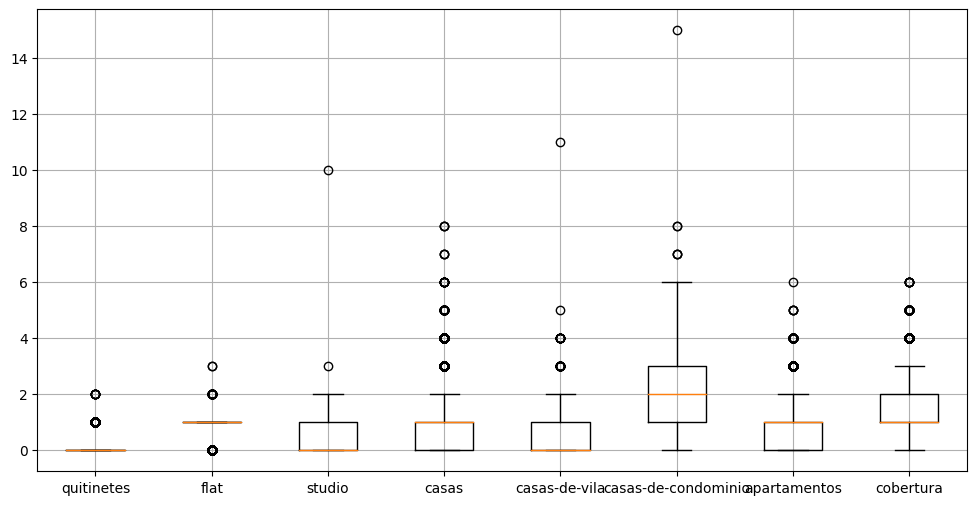

In [266]:
fig = plt.figure(figsize=(12, 6))
plt.boxplot( [data[data['listing.suites'].notnull()].query('imvl_type == "quitinetes"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "flat"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "studio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-vila"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-condominio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "apartamentos"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "cobertura"')['listing.suites'] ],
             labels=['quitinetes', 'flat', 'studio', 'casas', 'casas-de-vila', 'casas-de-condominio','apartamentos', 'cobertura'])
plt.grid()   
plt.show()

In [269]:
data.query('imvl_type == "studio" and `listing.suites`> 4')['listing.suites']

48757    10.0
Name: listing.suites, dtype: float64

In [270]:
data.drop(data.query('imvl_type == "studio" and `listing.suites`> 4').index, inplace=True)

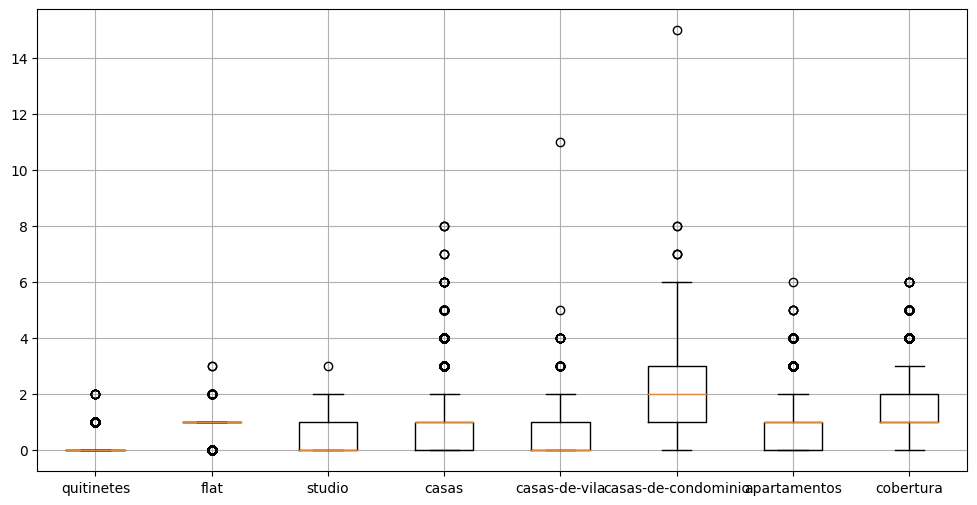

In [271]:
fig = plt.figure(figsize=(12, 6))
plt.boxplot( [data[data['listing.suites'].notnull()].query('imvl_type == "quitinetes"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "flat"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "studio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-vila"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "casas-de-condominio"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "apartamentos"')['listing.suites'], 
              data[data['listing.suites'].notnull()].query('imvl_type == "cobertura"')['listing.suites'] ],
             labels=['quitinetes', 'flat', 'studio', 'casas', 'casas-de-vila', 'casas-de-condominio','apartamentos', 'cobertura'])
plt.grid()   
plt.show()

array([[<Axes: title={'center': 'ALUGUEL'}>,
        <Axes: title={'center': 'listing.address.point.lat'}>,
        <Axes: title={'center': 'listing.address.point.lon'}>],
       [<Axes: title={'center': 'listing.bathrooms'}>,
        <Axes: title={'center': 'listing.bedrooms'}>,
        <Axes: title={'center': 'listing.parkingSpaces'}>],
       [<Axes: title={'center': 'listing.pricingInfo.monthlyCondoFee'}>,
        <Axes: title={'center': 'listing.pricingInfo.yearlyIptu'}>,
        <Axes: title={'center': 'listing.suites'}>],
       [<Axes: title={'center': 'listing.usableAreas'}>, <Axes: >,
        <Axes: >]], dtype=object)

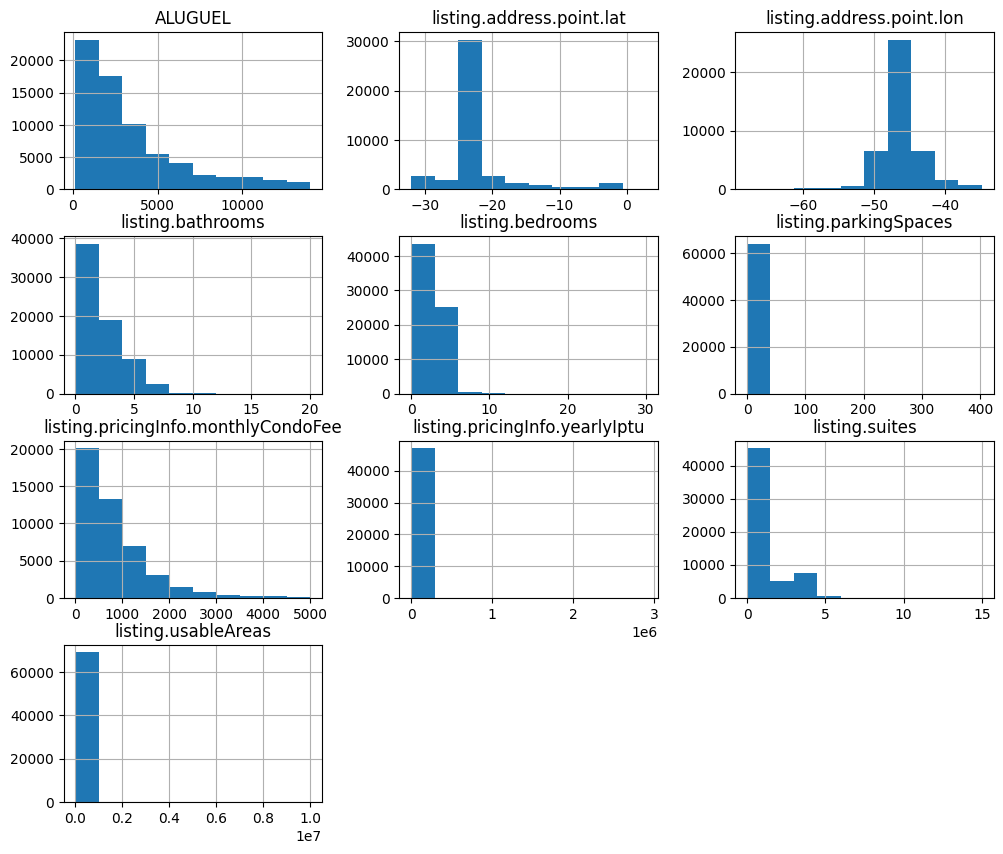

In [273]:
data.hist(figsize=(12, 10))